# Figure 6

[Skip code and jump to the figure](#Show-the-figure)

----------------------------------

In [1]:
import warnings

warnings.filterwarnings("ignore")  # noqa

In [2]:
# Scientific and datavis stack
import iris
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# My packages
from aeolus.calc import spatial_mean, water_path, deriv
from aeolus.const import add_planet_conf_to_cubes, init_const
from aeolus.coord import get_cube_rel_days, roll_cube_pm180, isel
from aeolus.core import AtmoSim
from aeolus.io import load_data
from aeolus.model import um, um_stash
from aeolus.plot import add_custom_legend, subplot_label_generator, tex2cf_units
from pouch.clim_diag import calc_derived_cubes
from pouch.plot import KW_MAIN_TTL, KW_SBPLT_LABEL, figsave, use_style

In [4]:
# Local modules
import mypaths
from commons import GLM_SUITE_ID, SIM_LABELS, cold_traps

Apply custom matplotlib style sheet.

In [5]:
use_style()

## Load the data for the two key experiments

Define paths to input data and results.

In [6]:
img_prefix = f"{GLM_SUITE_ID}_spinup"
inp_dir = mypaths.sadir / f"{GLM_SUITE_ID}_spinup"
time_prof = "mean_days0_499"
plotdir = mypaths.plotdir / img_prefix

Load processed data.

In [7]:
runs = {}
for sim_label, sim_prop in SIM_LABELS.items():
    planet = sim_prop["planet"]
    const = init_const(planet, directory=mypaths.constdir)

    cl = load_data(
        files=inp_dir / f"{GLM_SUITE_ID}_{sim_label}_raddiag.nc",
    )
    cl = iris.cube.CubeList([roll_cube_pm180(cube) for cube in cl])
    lw_up_forcing = cl.extract_cube(um_stash.lw_up_forcing)
    lw_up_forcing.rename(um.lw_up_forcing)
    lw_up_forcing.units = cl.extract_cube(um.lw_up).units
    lw_dn_forcing = cl.extract_cube(um_stash.lw_dn_forcing)
    lw_dn_forcing.rename(um.lw_dn_forcing)
    lw_dn_forcing.units = cl.extract_cube(um.lw_dn).units
    cl += load_data(
        files=inp_dir / f"{GLM_SUITE_ID}_{sim_label}_{time_prof}.nc",
    )
    cldtop = cl.extract_cube("m01s09i223")
    cldtop.rename("total_cloud_top_height")
    cldtop.units = "kft"

    add_planet_conf_to_cubes(cl, const)
    # Derive additional fields
    calc_derived_cubes(cl, const=const, model=um)
    # Use the cube list to initialise an AtmoSim object
    runs[sim_label] = AtmoSim(
        cl,
        name=sim_label,
        planet=planet,
        const_dir=mypaths.constdir,
        timestep=cl[-1].attributes["timestep"],
        model=um,
        vert_coord="z",
    )

Define diagnostics for the night-side surface heat balance.

In [8]:
DIAGS = {
    "dt_sfc_dt": {
        "cube": lambda AS: deriv(spatial_mean(AS.t_sfc.extract(cold_traps)), um.t),
        "method": "plot",
        "kw_plt": dict(
            color="tab:blue",
        ),
        "title": "Change in surface temperature",
        "tex_units": "$K$ $day^{-1}$",
        "lim": [-1, 1],
        "ax": 0,
    },
    "sfc_net_down_lw": {
        "cube": lambda AS: spatial_mean(AS.sfc_net_down_lw.extract(cold_traps)),
        "method": "plot",
        "kw_plt": dict(
            color="tab:green",
        ),
        "title": "Net downward LW radiation",
        "ylabel": "Air-sea energy flux",
        "tex_units": "$W$ $m^{-2}$",
        "lim": [-50, 50],
        "ax": 1,
    },
    "sfc_shf": {
        "cube": lambda AS: -1 * spatial_mean(AS.sfc_shf.extract(cold_traps)),
        "method": "plot",
        "kw_plt": dict(color="tab:green", linestyle="--", dash_capstyle="round"),
        "title": "Downward sensible heat flux",
        "tex_units": "$W$ $m^{-2}$",
        "ylabel": "Air-sea energy flux",
        "lim": [-50, 50],
        "ax": 1,
    },
    "sfc_lhf": {
        "cube": lambda AS: -1 * spatial_mean(AS.sfc_lhf.extract(cold_traps)),
        "method": "plot",
        "kw_plt": dict(color="tab:green", linestyle=":", dash_capstyle="round"),
        "title": "Downward latent heat flux",
        "ylabel": "Air-sea energy flux",
        "tex_units": "$W$ $m^{-2}$",
        "lim": [-50, 50],
        "ax": 1,
    },
    "sfc_down_lw": {
        "cube": lambda AS: spatial_mean(AS.sfc_dn_lw.extract(cold_traps)),
        "method": "plot",
        "kw_plt": dict(
            color="tab:orange",
        ),
        "title": "Downward LW radiation",
        "tex_units": "$W$ $m^{-2}$",
        "lim": [0, 220],
        "ax": 2,
    },
    ######################
    "wvp": {
        "cube": lambda AS: spatial_mean(water_path(AS._cubes.extract(cold_traps))),
        "method": "plot",
        "kw_plt": dict(
            color="tab:purple",
        ),
        "title": "Water vapour path",
        "ylabel": "Water path",
        "tex_units": "$kg$ $m^{-2}$",
        "lim": [0, 15],
        "ax": 0,
    },
    "cwp": {
        "cube": lambda AS: spatial_mean(
            water_path(AS._cubes.extract(cold_traps), kind="cloud_water")
        )
        * 10,
        "method": "plot",
        "kw_plt": dict(
            color="tab:purple",
            linestyle=":",
            dash_capstyle="round",
        ),
        "title": r"Cloud water path ($\times 10$)",
        "ylabel": "Water path",
        "tex_units": "$kg$ $m^{-2}$",
        "lim": [0, 10],
        "ax": 0,
    },
    "wvre_lw_sfc": {
        "cube": lambda AS: spatial_mean(
            isel(AS.lw_dn_forcing - AS.lw_dn, um.z, 0).extract(cold_traps)
        ),
        "method": "plot",
        "kw_plt": dict(
            color="tab:red",
        ),
        "title": "$WVRE_{LW}^{sfc}$",
        "tex_units": "$W$ $m^{-2}$",
        "lim": [-150, 150],
        "ticks": np.arange(-150, 151, 25),
        "ylabel": "LW radiative effect",
        "ax": 1,
    },
    "cre_lw_sfc": {
        "cube": lambda AS: spatial_mean(
            (AS.sfc_dn_lw_cs - AS.sfc_dn_lw).extract(cold_traps)
        ),
        "method": "plot",
        "kw_plt": dict(
            color="tab:red",
            linestyle=":",
            dash_capstyle="round",
        ),
        "title": "$CRE_{LW}^{sfc}$",
        "tex_units": "$W$ $m^{-2}$",
        "ylabel": "LW radiative effect",
        "lim": [-150, 150],
        "ax": 1,
    },
    "t_sfc": {
        "cube": lambda AS: spatial_mean(AS.t_sfc.extract(cold_traps)),
        "method": "plot",
        "kw_plt": dict(
            color="tab:blue",
        ),
        "title": "Surface temperature",
        "tex_units": "$K$",
        "lim": [170, 260],
        "ax": 2,
    },
}

Define which diagnostics to show.

In [9]:
vrbls_to_show = [
    "dt_sfc_dt",
    "sfc_net_down_lw",
    "sfc_shf",
    "sfc_lhf",
    "sfc_down_lw",
]

Do the calculations and store results in a separate dictionary.

In [10]:
RESULTS = {}
for sim_label in SIM_LABELS.keys():
    the_run = runs[sim_label]
    RESULTS[sim_label] = {}
    for vrbl_key in vrbls_to_show:
        vrbl_prop = DIAGS[vrbl_key]
        cube = vrbl_prop["cube"](the_run)
        cube.convert_units(tex2cf_units(vrbl_prop["tex_units"]))
        RESULTS[sim_label][vrbl_key] = cube

### Create a figure

In [11]:
imgname = f"{img_prefix}__{'_'.join(SIM_LABELS)}__{'_'.join(vrbls_to_show)}__cold_traps"
xlim = [0, 500]
ncols = 2
nrows = 1
window = 10
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols * 8.5, nrows * 4))
iletters = subplot_label_generator()
for sim_label, ax in zip(SIM_LABELS.keys(), axs.flat):
    ax.set_title(f"{next(iletters)}", **KW_SBPLT_LABEL)
    ax.set_title(SIM_LABELS[sim_label]["title"], **KW_MAIN_TTL)
    ax.set_xlabel("Time [day]")
    n_axes = len(set([DIAGS[vrbl_key].get("ax", 0) for vrbl_key in vrbls_to_show]))
    twinx_axes = [ax]
    for _ in range(n_axes - 1):
        twinx_axes.append(ax.twinx())
    if len(twinx_axes) >= 3:
        for i, ax in enumerate(twinx_axes[2:]):
            if ax.is_last_col():
                x_off = 1.14 + i * 0.05
            else:
                x_off = 1.08 + i * 0.05
            ax.spines["right"].set_position(("axes", x_off))

    for i, vrbl_key in enumerate(vrbls_to_show):
        vrbl_prop = DIAGS[vrbl_key]
        the_run = runs[sim_label]
        # Calculate diagnostics
        cube = RESULTS[sim_label][vrbl_key]
        # cube_rm = rolling_mean(cube, um.t, window=window)
        # Plot diagnostics
        _ax = twinx_axes[vrbl_prop.get("ax", 0)]

        if (_ax.is_first_col() and (vrbl_prop.get("ax", 0) == 0)) or (
            not _ax.is_first_col() and (vrbl_prop.get("ax", 0) != 0)
        ):
            _ax.set_ylabel(
                f'{vrbl_prop.get("ylabel", vrbl_prop["title"])} [{vrbl_prop["tex_units"]}]',
                color=vrbl_prop["kw_plt"]["color"],
                fontsize="medium",
            )
        _ax.set_ylim(vrbl_prop["lim"])
        if "ticks" in vrbl_prop:
            _ax.set_yticks(vrbl_prop["ticks"])
        _ax.set_xlim(xlim)
        if min(vrbl_prop["lim"]) < 0 and max(vrbl_prop["lim"]) > 0:
            _ax.hlines(0, *xlim, alpha=0.25, color=vrbl_prop["kw_plt"]["color"])
        _ax.tick_params(
            axis="y", labelcolor=vrbl_prop["kw_plt"]["color"], labelsize="x-small"
        )
        _ax.plot(
            get_cube_rel_days(cube),
            cube.data,  # cube_rm
            linewidth=1.5,
            **vrbl_prop["kw_plt"],
            label=vrbl_prop["title"],
        )
add_custom_legend(
    fig,
    {
        DIAGS[vrbl_key]["title"]: {"linewidth": 3, **DIAGS[vrbl_key]["kw_plt"]}
        for vrbl_key in vrbls_to_show
    },
    loc="upper center",
    bbox_to_anchor=(0.5, 1.25),
    frameon=False,
    ncol=3,
    title="Spin-up time series for the cold traps region",
)
plt.close()

# Show the figure

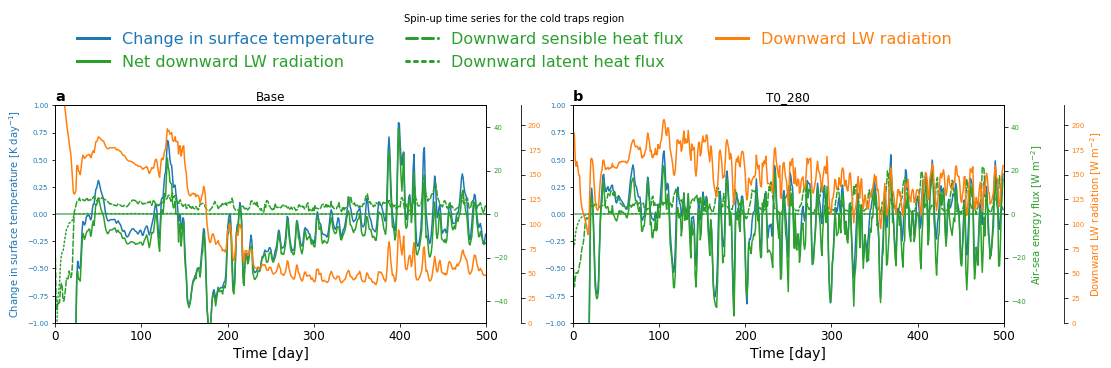

In [12]:
fig

* **Time series of diagnostics for the night-side cold traps, defined as the region bounded by $45^\circ$ and $55^\circ$ in the latitude and $160^\circ-140^\circ$W in the longitude.**
* **The panels for the (left) SJ and (right) DJ regime show: (purple, solid) water vapor path in $kg\,m^{-2}$, (purple, dashed) cloud water path in $\times 10\,kg\,m^{-2}$, (red, solid) water vapor radiative effect $WVRE_{LW}^{sfc}$ in $W\,m^{-2}$, (red, dashed) cloud radiative effect $CRE_{LW}^{sfc}$ in $W\,m^{-2}$, and (blue) surface temperature in $K$.**
* **$WVRE_{LW}^{sfc}$ is defined as the difference between the radiative fluxes at the surface calculated with and without the water vapor opacity.**
* **Likewise, the $CRE_{LW}^{sfc}$ is defined as the difference between the "clear-sky" and "cloudy" radiative fluxes at the surface.**

In [13]:
figsave(fig, plotdir / imgname)

Saved to ../plots/ch111_spinup/ch111_spinup__base_sens-t280k__dt_sfc_dt_sfc_net_down_lw_sfc_shf_sfc_lhf_sfc_down_lw__cold_traps.png
